# LMM SABR
Requires:
- Fwd-fwd corr (forward_curve_corr)
- Vol-Vol corr (caplet_fitting)
- Fwd-Vol corr (forward_curve_corr)
- Current Fwd Curve (F_0) (caplet_fitting)
- correction terms for volatility (caplet_fitting)
- correction terms for vol-vol (caplet_fitting)
- g(T-t) parameters for volatility parametric function fit (caplet_fitting)
- h(T-t) parameters for vol-vol parametric function fit (caplet_fitting)

In [63]:
#load libraries
import math
import numpy as np
import warnings
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
from matplotlib import cm

In [19]:
def load_object(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)

In [37]:
path_params = os.path.join(os.getcwd(), "parameters")
path_results = os.path.join(os.getcwd(), "simulation_results")


forwards = load_object(path_params+"\\spot_forwards.pkl")
s0_exp = load_object(path_params+"\\vol_initial_correction.pkl")
epsilon_exp = load_object(path_params+"\\volvol_initial_correction.pkl")
doust_fwd_fwd = load_object(path_params+"\\fwdfwd_corr.pkl")
doust_vol_vol = load_object(path_params+"\\volvol_corr.pkl")
corr_fwd_vol = load_object(path_params+"\\fwdvol_corr.pkl")
params_g = load_object(path_params+"\\vol_params_g.pkl")
params_h= load_object(path_params+"\\volvol_params_h.pkl")
spots= load_object(path_params+"\\spot_rates.pkl")

caplet_vol_mat= load_object(path_params+"\\caplet_vol_mat.pkl")
caplet_strike_mat= load_object(path_params+"\\caplet_strike_mat.pkl")


In [38]:
# load caplets price data for comparison
with open(os.path.join(os.getcwd(), "raw_dataset", "caplet_raw.xlsx"), 'rb') as file:
    raw_caplet_mkt_prc = pd.read_excel(file, sheet_name = 3, header = 0)

caplet_mkt_prc_mat = np.array(raw_caplet_mkt_prc.iloc[:, :8])

In [39]:
#reduce ranking
def reduceRank(corr_matrix , no_of_factors):
    '''
    reduce rank eigenvalue zeroing technique.
    @var corr_matrix: input correlation matrix
    containing the forward -forward correlations
    @var no_of_factors: number of factors that we want to employ
    '''
    B = None
    reduced_cov_matrix = None
    reduced_corr_matrix = np.zeros_like(corr_matrix)
    Q, lambda_ , Q_inv = np.linalg.svd( corr_matrix)
    H = np.zeros (( corr_matrix.shape [0], no_of_factors ))
    for i in range(no_of_factors ):
        H[i,i] = np.sqrt(lambda_[i])
    B = Q.dot(H)
    reduced_cov_matrix = B.dot(B.T)
    # Transform the covariance matrix into a correlation # matrix
    for i in range(corr_matrix.shape [0]):
        for j in range(corr_matrix.shape [0]):
                reduced_corr_matrix[i,j] = (reduced_cov_matrix[i,j]/\
                (np.sqrt( reduced_cov_matrix[i,i] * \
                reduced_cov_matrix[j,j])))
    return B, reduced_corr_matrix


In [40]:
def drawRandomNumbers (no_of_factors , cholesky):
    '''
    Draw a set of random numbers.
    @var no_of_factors: number of factors that we want
    to employ.
    @var cholesky: Cholesky decomposition of the
    correlation matrix describing the correlation
    among the random variables to simulate.
    '''
    if no_of_factors > 1:
        rand = np.random.normal(size = no_of_factors)
        return cholesky.dot(rand)
    else:
        return np.random.normal ()


def getInstantaneousVolatility(t, expiry , params):
    '''
    Return the instantaneous volatility ,
    computed in terms of the parametric
    form proposed by Rebonato , at a given time t.
    @var t: time at which we want to compute the
    instantaneous volatility (in years)
    @var expiry: caplet expiry (in years)
    @var a: parameter a of Rebonato ’s instant. vol. function
    @var b: parameter b of Rebonato ’s instant. vol. function
    @var c: parameter c of Rebonato ’s instant. vol. function
    @var d: parameter d of Rebonato ’s instant. vol. function
    
    #g(T - t) & h(T - t)
    '''
    a,b,c,d = params
    tau = expiry - t
    instantaneous_vol = (a + b * tau) * np.exp(-c * tau) + d
    return instantaneous_vol

In [41]:

# =============================================================================
# under Terminal Measure Q^N
# =============================================================================


def simulateSABRLMM(no_of_sim , steps_per_year,
    fixing_time_grid , F_0 , s_0 , epsilon , corr_fwd_fwd_full_rank ,
    corr_vol_vol_full_rank, corr_fwd_vol, no_of_factors , beta , tau ,
    params_g, params_h, seed = 123):
    '''
    Monte Carlo SABR LMM using Euler scheme.
    @var no_of_sim : Monte Carlo paths
    @var no_of_steps : discretization steps required
    to reach the option expiry date
    @var fixing_time_grid : list containing the forward fixing times (start at 0.5)
    @var F_0: list of forward rate values at time t=0
    @var s_0: list of correction terms s
    @var epsilon: list of correction terms epsilon
    @var corr_fwd_fwd_full_rank : forward -forward full rank
    correlation matrix
    @var corr_vol_vol_full_rank : volatility - Volatility
    full rank correlation matrix
    @var no_of_factors : number of factors which we want
    to use in the simulation
    @var beta : List of beta values
    @var tau: forward rate rolling period (in years)
    @var a_g: parameter a of the g function
    @var b_g: parameter b of the g function
    @var c_g: parameter c of the g function
    @var d_g: parameter d of the g function
    @var a_h: parameter a of the h function
    @var b_h: parameter b of the h function
    @var c_h: parameter c of the h function
    @var d_h: parameter d of the h function
    '''
    np.random.seed(seed)
    
    no_of_fwds = len(F_0)
    
    # Get the Cholesky decomposition as well as the reduced
    # rank matrix from the full rank forward - forward
    # correlation matrix
    cholesky_fwd_fwd , corr_fwd_fwd = reduceRank (corr_fwd_fwd_full_rank ,
                                                  no_of_factors )
    
    # Get the Cholesky decomposition as well as the reduced
    # rank matrix from the full rank volatility - volatility
    # correlation matrix
    cholesky_vol_vol , corr_vol_vol = reduceRank (corr_vol_vol_full_rank,
                                                  no_of_factors )
    
    # Initialize variables
    F_t = np.array([0.0] * no_of_fwds)
    alpha_t = np.array([0.0] * no_of_fwds)
    s_t = np.array([1.0] * no_of_fwds)
    ds_t = np.array([0.0] * no_of_fwds)
    
    # Get the last LIBOR FIXING time.
    # It is the next to last element stored in the time grid
    last_fixing = fixing_time_grid[-1]
    
    
    sim_forwards = np.zeros((no_of_fwds, len(fixing_time_grid)+1, no_of_sim))
    sim_forwards[:, 0, :] = np.array(F_0).reshape(-1, 1)
    
    #no_of_steps
    no_of_steps = steps_per_year * last_fixing
    
    # Step length in years
    dt = last_fixing / float( no_of_steps )
    dt_sqrt = math.sqrt(dt)
    
    for no_sim in range(no_of_sim):
        
        t = 0
        no_step = 1
        
        
        for fwd_k in range(0, no_of_fwds ):
            s_t[fwd_k] = s_0[fwd_k]
            F_t[fwd_k] = F_0[fwd_k]
            ds_t [fwd_k] = 0.0
            
        # Simulate the processes along the steps till final fixing time along a path
        while no_step <= no_of_steps :
            # The t variable will be used to get the parametric
            # vol. and vol. of vol. corresponding to the
            # time step being simulated

            t = no_step * dt
            # Generate the correlated Brownian motions used to
            # simulate dF and ds
            dW_F = drawRandomNumbers (no_of_factors ,
            cholesky_fwd_fwd ) * dt_sqrt
            
            #brownian motion of ds
            dW_s = drawRandomNumbers (no_of_factors ,
            cholesky_vol_vol ) * dt_sqrt
            
            #initialize
            drift_F = 0.0
            shared_drift_part = np.zeros(no_of_fwds)
            drift_correction = np.zeros(no_of_fwds)
            
            # Simulate each forward rate , starting from the last one
            for i in range(1, no_of_fwds+1): 
                fwd_k = no_of_fwds - i #first forward never runs
                
                # The simulation is run only for forward rates which are still alive
                # maturity_grid [fwd_k - 1] == last fixing time
                
                if t < fixing_time_grid[fwd_k]:
                    g_t = getInstantaneousVolatility (t, \
                    fixing_time_grid[fwd_k], params_g)
                    
                    # g_t = np.sqrt( instant_vol_sq_poly (t, \
                    # maturity_grid [fwd_k - 1], params_g) )
                    
                    h_t = getInstantaneousVolatility(t, \
                    fixing_time_grid[fwd_k], params_h)
                        
                    # h_t = np.sqrt( instant_vol_sq_poly (t, \
                    # maturity_grid [fwd_k - 1], params_h) )
                        
                        
                    F_beta_t = math.pow(abs(F_t[fwd_k]), beta[fwd_k]) #F^beta for fwd_k
                    
                    ##drift of correction term s
                    drift_s = corr_fwd_vol[fwd_k, fwd_k] * h_t * s_t[fwd_k] * \
                                shared_drift_part[fwd_k]
                    
                    ds_t [fwd_k] = drift_s * dt + (h_t * epsilon[fwd_k] *
                    s_t[fwd_k] * dW_s [fwd_k])
                    
                    s_t[fwd_k] += ds_t [fwd_k]
                    
                    alpha_t[fwd_k] = g_t * s_t[fwd_k]
                    
                    # Zero absorbing boundary used for all the
                    # beta choices except beta = 0 and beta = 1
                    if (( beta [fwd_k] > 0 and beta [fwd_k] < 1)
                        and (F_t[fwd_k] <= 0)):
                        F_t[fwd_k] = 0.0
                    
                    else:
                        drift_F = (-g_t * s_t[fwd_k] * F_beta_t *
                        shared_drift_part[fwd_k])
                        
                        F_t[fwd_k] += (drift_F * dt +
                        alpha_t[fwd_k] *
                        F_beta_t * dW_F [fwd_k])
                        
                        
                        drift_correction[fwd_k - 1] = \
                        corr_fwd_fwd [fwd_k - 1, fwd_k] * (tau * \
                        g_t * s_t[fwd_k] * F_beta_t) / (1 + \
                        tau * F_t[fwd_k])
                        
                                                        
                        # Calculate the drift sum term to be used by the next forward
                        if fwd_k <= (no_of_fwds - 1):
                            shared_drift_part [fwd_k - 1] += np.sum(drift_correction[(fwd_k - 1):])
            
            no_step += 1
            # print(F_t[18])
            #store the forwards for each fixing time/grid
            # print(no_step)
            if (no_step+1)% (steps_per_year/2) == 0.0:
                   mature = int((no_step+1)/ (steps_per_year/2))
                   # print(mature)
                   sim_forwards[t <= fixing_time_grid, mature, no_sim] = F_t[t <= fixing_time_grid]
               
        # for fwd_k in range(0, no_of_fwds):
        #     simulated_forwards[fwd_k ,no_sim] = F_t[fwd_k]

    
    return sim_forwards

In [42]:
#define arguments to use for LMM SABR Simulation
no_of_sim = 1000 #change this
steps_per_year = 48
F_0 = forwards #from caplet_fitting.py
s_0 = s0_exp #from caplet_fitting.py
epsilon = epsilon_exp #from caplet_fitting.py
corr_fwd_fwd_full_rank = doust_fwd_fwd[:19, :19]
corr_vol_vol_full_rank = doust_vol_vol[:19, :19]
corr_fwd_vol = corr_fwd_vol #from caplet_fitting.py
no_of_factors = 6 #correlation factors reduce rank
beta = np.repeat(0, len(F_0))
tau = 0.5 #semi-annual forwards
fixing_time_grid = np.arange(1,20)/2

### Simulate LMM SABR with the above parameters
Takes a quite a bit of time to do \
1,000 paths ~ 5 mins

In [43]:
'''
simulated full fwd 20x20xpaths contains initial forward rates
with first row and column containing instantaneous fwd/spot rate
'''
simulated_fwd_full = simulateSABRLMM (no_of_sim  = no_of_sim, steps_per_year = steps_per_year,
                          fixing_time_grid = fixing_time_grid, F_0  = F_0, s_0  = s_0,
                          epsilon =epsilon, corr_fwd_fwd_full_rank = corr_fwd_fwd_full_rank,
                          corr_vol_vol_full_rank = corr_vol_vol_full_rank,
                          corr_fwd_vol = corr_fwd_vol, no_of_factors = no_of_factors ,
                          beta = beta, tau = tau, params_g = params_g, params_h = params_h)

simulated_fwd_full = np.vstack((np.zeros((1,simulated_fwd_full.shape[1], simulated_fwd_full.shape[2])),
                                simulated_fwd_full))

simulated_fwd_full[0,0,:] = spots[0]


In [50]:
#sample matrix for a single path
simulated_fwd_full[:5, :5, 0]

array([[0.0023178 , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.0024451 , 0.00291476, 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.0028982 , 0.00296872, 0.00380029, 0.        , 0.        ,
        0.        , 0.        ],
       [0.0030861 , 0.00427618, 0.00409398, 0.00400421, 0.        ,
        0.        , 0.        ],
       [0.004112  , 0.00536976, 0.00461825, 0.00418028, 0.00297111,
        0.        , 0.        ],
       [0.0046043 , 0.00541705, 0.00496204, 0.00464553, 0.00480222,
        0.00498321, 0.        ],
       [0.0065795 , 0.00756877, 0.00744585, 0.00682939, 0.00837904,
        0.00819462, 0.00900627]])

In [51]:
#convert to zero rates from simulated forward arrays
def forwards_to_zeros(forwards, spot_fwd):
    '''
    forwards = vector of semiannual forward rates with 0.5 spaced grid 
                with starting fixing date 0.5
    spot_fwd = 6mth spot fwd (short-rate)
    '''
    disc_bonds = np.array((1+spot_fwd/2)**(-1))
    zeros = (1 + forwards/2)**(-1)*disc_bonds
    zeros = np.hstack((disc_bonds, zeros))
    
    return(zeros)

#20x20 discount prices including initial discount rates
simulated_zeros_full = np.zeros_like(simulated_fwd_full)
for j in range(simulated_fwd_full.shape[1]):
    for k in range(simulated_fwd_full.shape[2]):
        simulated_zeros_full[j:, j, k] = forwards_to_zeros(simulated_fwd_full[(j+1):, j, k],
                                                          simulated_fwd_full[j, j, k])


In [52]:
#caplet pricer from forward simulated forward matrix

def european_caplet(full_fwd_mat, k, expiry):
    '''
    full_fwd_mat = 20x20xpaths fwd matrix including initial fwd
    k = strike
    #expiry = fixing time of reference rate/LIBOR in years(only accept semi-annuals)
    #assume 0.5 day count
    '''
    
    expiry = int(2*expiry)
    cur_fwd = full_fwd_mat[:, 0, 0]
    discount = forwards_to_zeros(cur_fwd[1:], cur_fwd[0])
    
    ref_rate = full_fwd_mat[expiry, expiry, :]
    price = np.maximum(ref_rate - k, 0) * 0.5 * discount[expiry]
    return(np.mean(price))

### Get caplet prices from simulated forwards from LMM-SABR

In [58]:
notional = 10000000 #10m
sim_caplet_prices = np.zeros_like(caplet_vol_mat)
for i in range(sim_caplet_prices.shape[0]):
    for j in range(sim_caplet_prices.shape[1]):
        sim_caplet_prices[i, j] = european_caplet(simulated_fwd_full,
                                                  caplet_strike_mat[i, j], fixing_time_grid[i])*notional

### Compare fit in notional amt

Text(0.5, 0.92, 'Caplet Price Surface LMM-SABR vs Market')

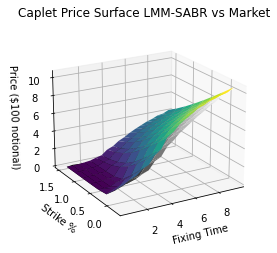

In [66]:
#plot
#Fit LMM SABR vs Market Prices excludeing ATM caplets in $100
#ATM caplets located at the end of caplet strike mat column
x_axs = np.tile(fixing_time_grid.reshape(-1,1), caplet_strike_mat[:, :-1].shape[1])
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(x_axs, caplet_strike_mat[:, :-1]*100, sim_caplet_prices[:, :-1]/10000, cmap = cm.gray, label = "MC-LMM-SABR")
ax.plot_surface(x_axs, caplet_strike_mat[:, :-1]*100, caplet_mkt_prc_mat/10000,cmap = cm.viridis, label = "Market")
ax.view_init(20, 240)
ax.set_xlabel('Fixing Time')
ax.set_ylabel('Strike %')
ax.set_zlabel('Price ($100 notional)')
ax.set_title('Caplet Price Surface LMM-SABR vs Market')

Fit is ok except for short maturity caplets which we assume is due to data error.

Text(0.5, 0.92, 'Caplet Price Surface LMM-SABR vs Market (% Difference)')

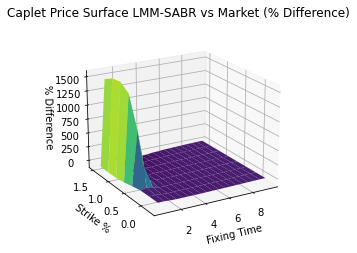

In [88]:
#percentage difference
diff = (sim_caplet_prices[:, :-1]/(caplet_mkt_prc_mat) - 1)*100 #in percentage

x_axs = np.tile(fixing_time_grid.reshape(-1,1), caplet_strike_mat[:, :-1].shape[1])
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(x_axs, caplet_strike_mat[:, :-1]*100, diff, cmap = cm.viridis, label = "MC-LMM-SABR")
ax.view_init(20, 240)
ax.set_xlabel('Fixing Time')
ax.set_ylabel('Strike %')
ax.set_zlabel('% Difference')
ax.set_title('Caplet Price Surface LMM-SABR vs Market (% Difference)')

### Save results

In [100]:
#wrapper function to run simulation and convert to zeros and save the simulated zeros paths
#also returns the simulated zeros
def simulate_paths(no_of_sim , steps_per_year,
    fixing_time_grid , F_0 , s_0 , epsilon , corr_fwd_fwd_full_rank ,
    corr_vol_vol_full_rank, corr_fwd_vol, no_of_factors , beta , tau ,
    params_g, params_h, seed = 123, spot_rates = None, save_path = None):
    
    simulated_fwd_full = simulateSABRLMM (no_of_sim  = no_of_sim, steps_per_year = steps_per_year,
                              fixing_time_grid = fixing_time_grid, F_0  = F_0, s_0  = s_0,
                              epsilon =epsilon, corr_fwd_fwd_full_rank = corr_fwd_fwd_full_rank,
                              corr_vol_vol_full_rank = corr_vol_vol_full_rank,
                              corr_fwd_vol = corr_fwd_vol, no_of_factors = no_of_factors ,
                              beta = beta, tau = tau, params_g = params_g, params_h = params_h, seed = seed)

    simulated_fwd_full = np.vstack((np.zeros((1,simulated_fwd_full.shape[1], simulated_fwd_full.shape[2])),
                                    simulated_fwd_full))

    simulated_fwd_full[0,0,:] = spot_rates[0]
        
    simulated_zeros_full = np.zeros_like(simulated_fwd_full)
    for j in range(simulated_fwd_full.shape[1]):
        for k in range(simulated_fwd_full.shape[2]):
            simulated_zeros_full[j:, j, k] = forwards_to_zeros(simulated_fwd_full[(j+1):, j, k],
                                                              simulated_fwd_full[j, j, k])
    
    print("Saving paths...")
    save_object(simulated_zeros_full, save_path)
    print("Succesfully saved object at: "+save_path)
    return(simulated_zeros_full)


def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

In [101]:
simulated_zeros = simulate_paths(no_of_sim  = no_of_sim, steps_per_year = steps_per_year,
                              fixing_time_grid = fixing_time_grid, F_0  = F_0, s_0  = s_0,
                              epsilon =epsilon, corr_fwd_fwd_full_rank = corr_fwd_fwd_full_rank,
                              corr_vol_vol_full_rank = corr_vol_vol_full_rank,
                              corr_fwd_vol = corr_fwd_vol, no_of_factors = no_of_factors ,
                              beta = beta, tau = tau, params_g = params_g, params_h = params_h, seed = 123, spot_rates = spots,
                              save_path = path_results+"\\simulated_zeros_1k.pkl")

Saving paths...
Succesfully saved object at: C:\Users\nhian\Dropbox\My PC (DESKTOP-L6D69LH)\Documents\GitHub\LMM_SABR\simulation_results\simulated_zeros_1k.pkl
